In [3]:

import numpy as np
import pandas as pd
from pathlib import Path
import scipy.stats  as stats
import matplotlib.pyplot as plt



### Data processing


In [7]:
#LOAD The data
path = 'dataset_mood_smartphone.csv'
df = pd.read_csv(path, header=0, sep=',', index_col=0)

#Split time column into time and date
date, time = df['time'].str.split(' ', 1).str
df.drop(labels=['time'], axis=1,inplace = True)
df.insert(1, 'date', date)
df.insert(2, 'time', time)

#sort on id and date
df = df.sort_values(by=['id', 'date'])

#Get the unique id's and data variables
ids = df.id.unique()
inputs = df.variable.unique()
uniquedays = df.date.unique()


In [6]:
#function to merge the days of the variables per patient  ##Note takes a while to complete
def mergedays(df):
    table = pd.DataFrame(columns=['id','date', 'variable', 'value'])
    ids = df.id.unique()
    #Rebuild the dataframe for every patient, day , variable
    i = 0
    for patientid in ids:
        patientdata = df.loc[df['id'] == patientid]
        days = patientdata.date.unique()
        for day in days:
            daydata = patientdata.loc[patientdata['date'] == day]
            variables = daydata.variable.unique()
            for var in variables:
                if var == 'mood' or var == 'circumplex.arousal' or var == 'circumplex.valence':
                    value = daydata.loc[daydata['variable'] == var].mean()[0]
                elif var == 'activity':
                    value = daydata.loc[daydata['variable'] == var].max()[4]
                else:
                    #note due to sum suming over all indexing is needed
                    value = daydata.loc[daydata['variable'] == var].sum()[4]

                #print([patientid,day,var,value])
                table.loc[i] = [patientid,day,var,value]
                i+=1
    return table

In [15]:
#STATUS PRINTS      #NOTE before cleaning
print("STATISTICS")
print("The amount of unique ids are: ", len(ids), "\n", ids)
print("Amount of unique days are: ", len(uniquedays), "\n", uniquedays)
print("\nThe variables used are:\n", inputs)

print("\nErrors are within:  circumplex.valence 156 NA & circumplex.arousal 46 NA")
print("The count and amount of data inputs do not match")

print("\nHow many data points per id:")
datalist = []
for i in ids:
    datalist.append(len(df.loc[df['id'] == i]))
    print(i, " amount of data inputs: ", len(df.loc[df['id'] == i]))

vardatalist = []
print("\nHow often are the variables used:")
for j in inputs:
    vardatalist.append(len(df.loc[df['variable'] == j]))
    print(j, "\nAmount of data inputs: ", len(df.loc[df['variable'] == j]))
    print(df.loc[df['variable'] == j].describe(),"\n")
    
    



STATISTICS
The amount of unique ids are:  27 
 ['AS14.01' 'AS14.02' 'AS14.03' 'AS14.05' 'AS14.06' 'AS14.07' 'AS14.08'
 'AS14.09' 'AS14.12' 'AS14.13' 'AS14.14' 'AS14.15' 'AS14.16' 'AS14.17'
 'AS14.19' 'AS14.20' 'AS14.23' 'AS14.24' 'AS14.25' 'AS14.26' 'AS14.27'
 'AS14.28' 'AS14.29' 'AS14.30' 'AS14.31' 'AS14.32' 'AS14.33']
Amount of unique days are:  113 
 ['2014-02-17' '2014-02-18' '2014-02-19' '2014-02-20' '2014-02-21'
 '2014-02-22' '2014-02-25' '2014-02-26' '2014-02-27' '2014-02-28'
 '2014-03-01' '2014-03-03' '2014-03-05' '2014-03-06' '2014-03-07'
 '2014-03-10' '2014-03-11' '2014-03-12' '2014-03-13' '2014-03-14'
 '2014-03-15' '2014-03-16' '2014-03-17' '2014-03-18' '2014-03-19'
 '2014-03-20' '2014-03-21' '2014-03-22' '2014-03-23' '2014-03-24'
 '2014-03-25' '2014-03-26' '2014-03-27' '2014-03-28' '2014-03-29'
 '2014-03-30' '2014-03-31' '2014-04-01' '2014-04-02' '2014-04-03'
 '2014-04-04' '2014-04-05' '2014-04-06' '2014-04-07' '2014-04-08'
 '2014-04-09' '2014-04-10' '2014-04-11' '2014-04-1

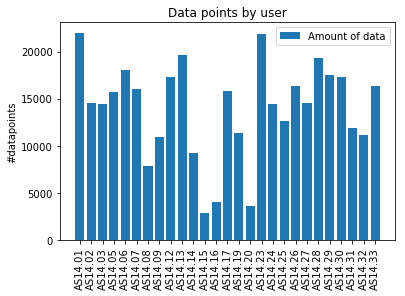

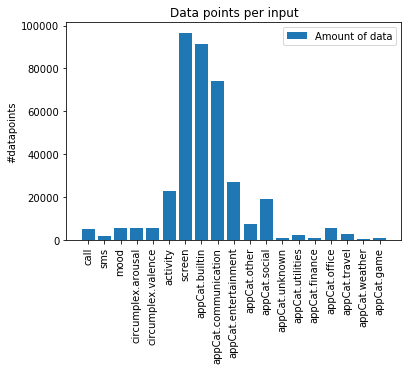

In [23]:
#plot the data points per id
fig, ax = plt.subplots()
ax.bar(np.arange(len(ids)),datalist,0.8,label='Amount of data')
ax.set_ylabel('#datapoints')
ax.set_title('Data points by user')
ax.set_xticks(np.arange(len(ids)))
ax.set_xticklabels(('AS14.01','AS14.02','AS14.03','AS14.05','AS14.06','AS14.07','AS14.08'
 ,'AS14.09', 'AS14.12', 'AS14.13','AS14.14','AS14.15','AS14.16','AS14.17',
 'AS14.19', 'AS14.20', 'AS14.23', 'AS14.24', 'AS14.25', 'AS14.26','AS14.27',
 'AS14.28', 'AS14.29', 'AS14.30','AS14.31','AS14.32','AS14.33'),rotation='vertical')
ax.legend()
plt.show()


#plot data points per variable
fig, bx = plt.subplots()
bx.bar(np.arange(len(inputs)),vardatalist,0.8,label='Amount of data')
bx.set_ylabel('#datapoints')
bx.set_title('Data points per input')
bx.set_xticks(np.arange(len(inputs)))
bx.set_xticklabels(('call','sms','mood','circumplex.arousal','circumplex.valence','activity'
 ,'screen','appCat.builtin','appCat.communication','appCat.entertainment'
 ,'appCat.other','appCat.social','appCat.unknown','appCat.utilities'
 ,'appCat.finance','appCat.office','appCat.travel','appCat.weather'
 ,'appCat.game'),rotation='vertical')
bx.legend()
plt.show()

In [12]:
#Correlations
#NOTE assumes the cleaned data  FROM 2 cells below. TODO SWITCH ORDER. not done due to git
def correlations(df):
    patients = df.id.unique().tolist()
    variables = df.variable.unique().tolist()
    variables.remove('mood')
    for patientid in patients:
        print("Correlations for patient:  ", patientid)
        for var in variables:
            cor = corrperpatient(patientid, var)
            print(var,"    : " ,cor[var].loc['mood'])
        print("------------------------------------------\n")
    
def checkio(data):
    for index in range(len(data) - 1, -1, -1):
        if data.count(data[index]) == 1:
            del data[index]
    return np.unique(data)

def corrperpatient(patientid, var):
    test = df.loc[df['id'] == patientid]
    moodcol = test.loc[(test['variable'] == 'mood')]
    mooddays = moodcol.date.unique()
    varcol = test.loc[(test['variable'] == var )]
    vardays = varcol.date.unique()
    
    validdates = checkio(list(np.append(mooddays,vardays)))
    moodlist = []
    varlist = []
    for day in validdates:
        moodlist.append(moodcol.loc[(moodcol['date'] == day)]['value'].item())
        varlist.append(varcol.loc[(varcol['date'] == day)]['value'].item())
    d = {'mood': moodlist, var: varlist}
    cordata = pd.DataFrame(data=d)
    return cordata.corr()

# correlations(df)
print(df.loc[df['variable'] == 'activity'])


            id        date  variable     value
37     AS14.01  2014-03-20  activity  0.091667
50     AS14.01  2014-03-21  activity  0.798387
65     AS14.01  2014-03-22  activity  0.508475
80     AS14.01  2014-03-23  activity  0.313559
93     AS14.01  2014-03-24  activity  0.361345
108    AS14.01  2014-03-25  activity  0.594828
122    AS14.01  2014-03-26  activity  0.822034
134    AS14.01  2014-03-27  activity  0.640000
150    AS14.01  2014-03-28  activity  0.638655
165    AS14.01  2014-03-29  activity  0.436975
179    AS14.01  2014-03-30  activity  0.277778
191    AS14.01  2014-03-31  activity  0.333333
207    AS14.01  2014-04-01  activity  0.785124
223    AS14.01  2014-04-02  activity  0.286885
237    AS14.01  2014-04-03  activity  0.228814
251    AS14.01  2014-04-04  activity  0.483051
265    AS14.01  2014-04-05  activity  0.541667
277    AS14.01  2014-04-06  activity  0.593220
290    AS14.01  2014-04-07  activity  0.400000
305    AS14.01  2014-04-08  activity  0.355932
318    AS14.0

In [8]:
# Clean data from NA
df = df.dropna(axis=0, how='any')

###Check to see the cleaning result
# print("\nHow often are the variables used:")
# for j in inputs:
#     print(j, "\nAmount of data inputs: ", len(df.loc[df['variable'] == j]))
#     print(df.loc[df['variable'] == j].describe(),"\n")
###
# print(df)

In [9]:
#Write / load the data

fname = "adjusted_data_activ.csv"
my_file = Path(fname)
if my_file.exists():
    print("file found, loading in now")
    df = pd.read_csv(fname, header=0, sep=',', index_col=0)
else:
    print("file not found")
    df = mergedays(df)
    df.to_csv(fname, sep=',')
    print("writing completed")

print(df)

file not found
writing completed
            id        date              variable        value
0      AS14.01  2014-02-17                  call     2.000000
1      AS14.01  2014-02-18                  call     1.000000
2      AS14.01  2014-02-19                  call     7.000000
3      AS14.01  2014-02-19                   sms     2.000000
4      AS14.01  2014-02-20                  call     2.000000
5      AS14.01  2014-02-20                   sms     3.000000
6      AS14.01  2014-02-21                   sms     1.000000
7      AS14.01  2014-02-22                  call     2.000000
8      AS14.01  2014-02-22                   sms     1.000000
9      AS14.01  2014-02-25                  call     3.000000
10     AS14.01  2014-02-26                  mood     6.250000
11     AS14.01  2014-02-26    circumplex.arousal    -0.250000
12     AS14.01  2014-02-26    circumplex.valence     0.750000
13     AS14.01  2014-02-26                  call     1.000000
14     AS14.01  2014-02-26           

In [ ]:
# Feli
#TODO benchmark x=y 


In [ ]:
#Model one  Michael

In [ ]:
#Model two Cecilia